# Categorize NDVI data

This notebook stores the categories and categorization process for NDVI data.

## Import libraries

In [1]:
accesibilidad_urbana = '../../'

In [2]:
import os
import sys

import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

from pandas.api.types import CategoricalDtype

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join(accesibilidad_urbana))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

## Config notebook

In [3]:
city = 'Monterrey'
res = 10
# Saves classified data to local dir
save = True
output_save_dir = accesibilidad_urbana + "data/external/temporal_fromjupyter/classified_ndvi/"

## Load data

In [4]:
ndvi_schema = 'raster_analysis'
ndvi_folder = 'ndvi_analysis_hex'

query = f"SELECT * FROM {ndvi_schema}.{ndvi_folder} WHERE \"city\" LIKE \'{city}\' AND \"res\"={res}"
ndvi_gdf = aup.gdf_from_query(query, geometry_col='geometry')

# Show
print(ndvi_gdf.shape)
ndvi_gdf.head(2)

(100615, 11)


,hex_id,geometry,res,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,city
0,8a48a205965ffff,"POLYGON ((-100.35623 25.80426, -100.35555 25.8...",10,0.051743,0.022685,0.048870,0.086995,0.021908,0.065087,-0.000182,Monterrey
1,8a48a23a4c07fff,"POLYGON ((-100.37370 25.79974, -100.37302 25.8...",10,0.125783,0.043679,0.127433,0.172154,0.088035,0.084119,-0.001408,Monterrey


## Categorize NDVI

In [5]:
ndvi_gdf['ndvi_median_rango'] = np.nan
ndvi_gdf.loc[ndvi_gdf.ndvi_median>=0.6 , 'ndvi_median_rango'] = 'Alta densidad vegetal'
ndvi_gdf.loc[(ndvi_gdf.ndvi_median>=0.4 )&
             (ndvi_gdf.ndvi_median<0.6), 'ndvi_median_rango'] = 'Moderada densidad vegetal'
ndvi_gdf.loc[(ndvi_gdf.ndvi_median>=0.2)&
             (ndvi_gdf.ndvi_median<0.4), 'ndvi_median_rango'] = 'Mínima densidad vegetal'
ndvi_gdf.loc[(ndvi_gdf.ndvi_median>=0.1)&
             (ndvi_gdf.ndvi_median<0.2), 'ndvi_median_rango'] = 'Suelo'
ndvi_gdf.loc[(ndvi_gdf.ndvi_median<0.1), 'ndvi_median_rango'] = 'Suelo artificial/Agua/Piedra'


#Definir orden y convertir pct_inf_rango en categoría ordenada
categories = ['Suelo artificial/Agua/Piedra', 'Suelo', 'Mínima densidad vegetal', 'Moderada densidad vegetal', 'Alta densidad vegetal']
ndvi_gdf['ndvi_median_rango'] = pd.Categorical(ndvi_gdf['ndvi_median_rango'], categories=categories, ordered=True)

Text(0.5, 1.0, 'Índice de vegetación')

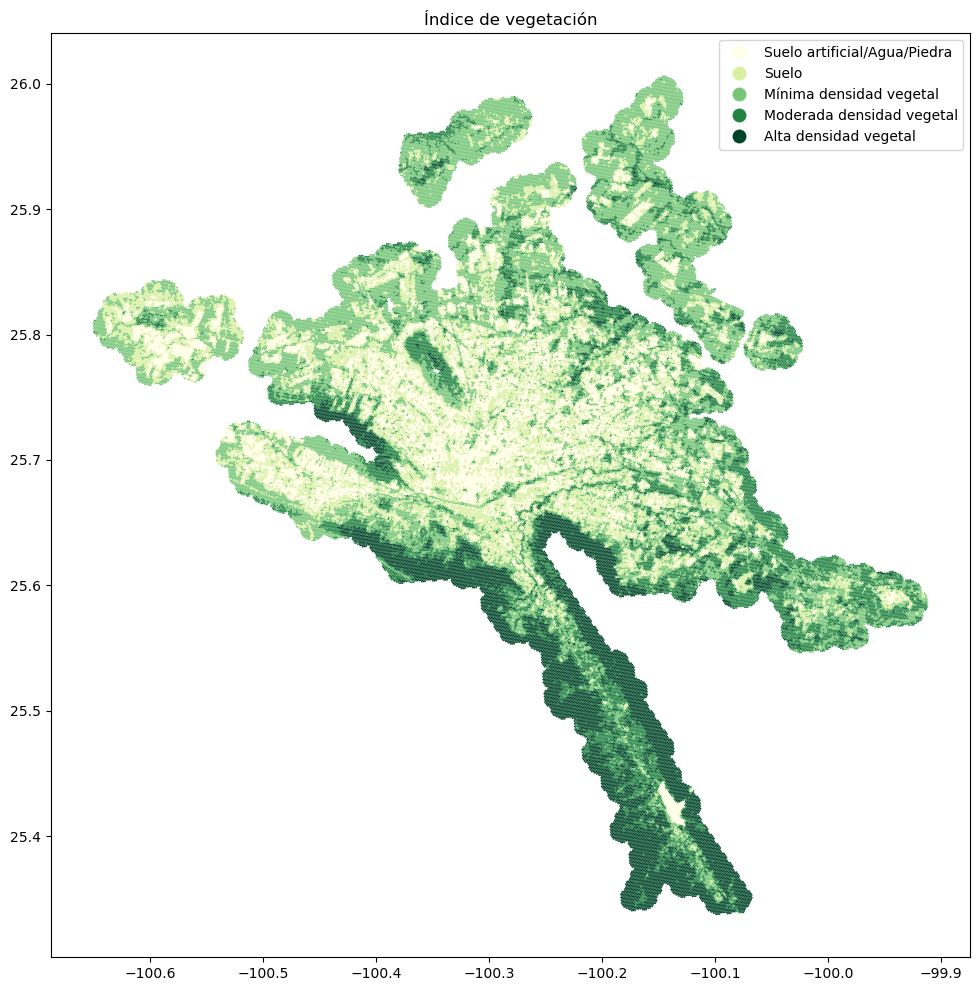

In [7]:
fig, ax = plt.subplots(1,1,figsize=(24,12))

ndvi_gdf.plot('ndvi_median_rango', 'YlGn', ax=ax, legend=True)
ax.set_title('Índice de vegetación')

In [14]:
if save:
    # Uncategorize function
    def uncategorize(col):
        if col.dtype.name == 'category':
            try:
                return col.astype(col.cat.categories.dtype)
            except:
                # In case there is pd.NA (pandas >= 1.0), Int64 should be used instead of int64
                return col.astype(col.cat.categories.dtype.name.title())           
        else:
            return col
    
    # Apply uncategorize function
    save_gdf = ndvi_gdf.copy()
    save_gdf = save_gdf.apply(uncategorize, axis=0)

    # Save
    save_gdf.to_file(output_save_dir+f"{city}_ndvi_res{res}_classified.gpkg")